In [133]:
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute, Aer, IBMQ
from qiskit.circuit import Parameter
from qiskit.visualization import plot_histogram
# Getting rid of unnecessary warnings
import warnings
from matplotlib.cbook import MatplotlibDeprecationWarning
warnings.filterwarnings('ignore', category=MatplotlibDeprecationWarning)
from qiskit.tools.visualization import plot_histogram

# Importing standard Qiskit libraries
from qiskit.compiler import transpile, assemble
#from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.circuit.library.standard_gates import XGate
from qiskit.circuit.library.standard_gates import RZGate
import math
from scipy import linalg
from numpy.linalg import solve
import scipy.stats
def bin4(m,a,b):#mをa桁の2進数にした時のb桁目
    m=int(m)
    #print(f'(m,a,b)=({m},{a},{b})')
    l = [*map(int,f"{format(m,'b'):>0{a}}")]
    return l[a-1-b]

def bin5(m,a):#mをa桁の2進数にした時の配列を返す
    m=int(m)
    #print(f'(m,a,b)=({m},{a},{b})')
    l = [*map(int,f"{format(m,'b'):>0{a}}")]
    return l

def decimal(n,a):#長さnのaという01配列を10進数に変換。
    answer=0
    for i in range(n):
        answer+=pow(2,n-1-i)*a[i]
        #answer+=pow2(n-1-i)*a[i]
    return answer


phi=Parameter('phi')
C2X=XGate().control(2)
C3X=XGate().control(3)
C4X=XGate().control(4)
C5X=XGate().control(5)
C6X=XGate().control(6)
C7X=XGate().control(7)
C8X=XGate().control(8)
C9X=XGate().control(9)
C10X=XGate().control(10)
C11X=XGate().control(11)
C1RZ=RZGate(phi).control(1)
C2RZ=RZGate(phi).control(2)
C3RZ=RZGate(phi).control(3)
C4RZ=RZGate(phi).control(4)
C5RZ=RZGate(phi).control(5)
C6RZ=RZGate(phi).control(6)
C7RZ=RZGate(phi).control(7)
C8RZ=RZGate(phi).control(8)
C9RZ=RZGate(phi).control(9)

def MCRZ(bit,n,qc,q,degree):
    #使い方の例：MCRZ(gate2[i],n,qc,q,B[i])
    m=sum(bit[0:n])
    a=[0 for i in range(n)]
    count=0
    for i in range(n):
        if bit[i]==1:
            a[count]=i
            count+=1
    a[m]=bit[n]#a[m]にtargetbitの場所
    #print(a)
    if m==0:
        qc.rz(degree,a[0])
    elif m==1:
        qc.crz(degree,a[0],a[1])
    elif m==2:
        qc.append(RZGate(degree).control(2),[a[0],a[1],a[2]])
    elif m==3:
        qc.append(RZGate(degree).control(3),[a[0],a[1],a[2],a[3]])
    elif m==4:
        qc.append(RZGate(degree).control(4),[a[0],a[1],a[2],a[3],a[4]])
    elif m==5:
        qc.append(RZGate(degree).control(5),[a[0],a[1],a[2],a[3],a[4],a[5]])
    elif m==6:
        qc.append(RZGate(degree).control(6),[a[0],a[1],a[2],a[3],a[4],a[5],a[6]])
    elif m==7:
        qc.append(RZGate(degree).control(7),[a[0],a[1],a[2],a[3],a[4],a[5],a[6],a[7]])
    elif m==8:
        qc.append(RZGate(degree).control(8),[a[0],a[1],a[2],a[3],a[4],a[5],a[6],a[7],a[8]])
    elif m==9:
        qc.append(RZGate(degree).control(9),[a[0],a[1],a[2],a[3],a[4],a[5],a[6],a[7],a[8],a[9]])
def MCX(m,qc):
    if m==3:
        qc.append(C2X,[0,1,2])
    elif m==4:
        qc.append(C3X,[0,1,2,3])
    elif m==5:
        qc.append(C4X,[0,1,2,3,4])
    elif m==6:
        qc.append(C5X,[0,1,2,3,4,5])
    elif m==7:
        qc.append(C6X,[0,1,2,3,4,5,6])
    elif m==8:
        qc.append(C7X,[0,1,2,3,4,5,6,7])
    elif m==9:
        qc.append(C8X,[0,1,2,3,4,5,6,7,8])
    elif m==10:
        qc.append(C9X,[0,1,2,3,4,5,6,7,8,9])
    elif m==11:
        qc.append(C10X,[0,1,2,3,4,5,6,7,8,9,10])
    elif m==12:
        qc.append(C11X,[0,1,2,3,4,5,6,7,8,9,10,11])


def function_n(n,ki,kw,kw_n):#kiは1次元(n**2)ベクトル、kwは2次元(n**2,kw_n)ベクトル
    bit=np.array([[0 for i in range(n)] for j in range(pow(2,n))], dtype=object)
    gate=np.array([[0 for i in range(n)] for j in range(pow(2,n))], dtype=object)
    gate2=np.array([[0 for i in range(n+1)] for j in range(pow(2,n))], dtype=object)#gate2行列を横に1つ拡張してtargetbitの場所を記録する。
    A=np.array([[0.0 for i in range(pow(2,n))] for j in range(pow(2,n))])#入るのは0,±1/2
    constant1=np.array([0.0 for i in range(pow(2,n))])#連立方程式の定数部分
    constant2=np.array([0.0 for i in range(pow(2,n))])#連立方程式の定数部分
    constant3=np.array([[0.0 for i in range(pow(2,n))] for j in range(pow(2,n))])
    B=np.array([0.0 for i in range(pow(2,n))])
    C=np.array([0.0 for i in range(pow(2,n))])
    D=np.array([[0.0 for i in range(pow(2,n))] for j in range(kw_n)])
    E=np.array([[0.0 for i in range(pow(2,n))] for j in range(kw_n)])
    FLAG=np.array([0 for i in range(pow(2,n))])
    X=np.array([0 for i in range(n)])
    for i in range(0,pow(2,n)):
        for j in range(0,n):
            bit[i][n-1-j]=bin4(i,n,j)
        #print(bit[i]) #0-pow(2,n)の2進数表記

    #gateを作成する。上から1の数が小さい順に並び変える。今回は下の方のbitを優先してcontrol bitにして適用される画素に偏りをなくす。
    a=1 #aは作成する行列の縦向きの番号,0番目は00...0で入力済み
    for i in range(1,n+1):
        for j in range(0,2**n):
            if sum(bit[2**n-j-1])==i:
                gate[a]=bit[2**n-j-1]
                a+=1

    #gate2を作成する。連立方程式で使う変数は2**n-1個(|00...0>は変化させない)だからその分だけ作る。gateで0になっている部分を1つだけ選んでその場所を一番右に記録する,gateより横に１つ大きい。
    a=1 #0行目は便宜的なもの。
    for i in range(0,2**n):
        for j in range(0,n):
            if gate[i][j]==0:
                for k in range(n):
                    gate2[a][k]=gate[i][k]
                gate2[a][n]=j
                a+=1
                #print(a)
            if a==2**n:
                break
        else:
            continue
        break
    #for i in range(2**n):
        #print(gate2[i])

    #ゲート毎の表を作成する。
    vertical_of_A=np.zeros(n)
    for i in range(0,2**n):
        for j in range(0,2**n):
            for k in range(0,n):
                vertical_of_A[k]=gate[j][k]-bit[i][k]#これに1が含まれていたらgateがbitを超越しているということ。
            if 1 not in vertical_of_A and bit[i][gate2[j][n]]==0:
                A[i][j]=-1/2
            elif 1 not in vertical_of_A and bit[i][gate2[j][n]]==1:
                A[i][j]=1/2
        constant1[i]=(pi/2)*(np.count_nonzero(A[i]!=0))#False(=0)ではないという意味
    #for i in range(2**n):
        #print(A[i])
    #print(A.shape)        
    constant2=ki-constant1-np.mean(ki-constant1)
    B=solve(A,constant2)
    #B=np.dot(np.linalg.inv(A),ki-constant)
    #invは行列式が0にならない正則行列の逆行列を求める(行列式が0では逆行列がない)
    #pinvは疑似的に逆行列を求めてくれる。
    #B=np.dot(np.linalg.pinv(A),ki-constant)
    B=B%(2*pi)

    for i in range(0,kw_n):
        for j in range(0,2**n):
            D[i][j]=(sum(bit[j])%2)*pi-kw[j]
        #E[i]=np.dot(np.linalg.inv(A),D[i]-constant)
        #E[i]=np.dot(np.linalg.pinv(A),D[i]-constant)
        constant3[i]=D[i]-constant1-np.mean(D[i]-constant1)
        E[i]=solve(A,constant3[i])
        E[i]=E[i]%(2*pi)

    q = QuantumRegister(n+1, 'q')
    c = ClassicalRegister(1, 'c')
    qc = QuantumCircuit(q, c)
    
    for i in range(n):
        qc.h(i)
        qc.barrier(i)
    for i in range(1,pow(2,n)):
            MCRZ(gate2[i],n,qc,q,B[i])
    for i in range(kw_n):
        for j in range(1,pow(2,n)):
            MCRZ(gate2[j],n,qc,q,E[i][j])
    for i in range(n):
        qc.h(i)
    MCX(n+1,qc)
    qc.measure(q[n],c[0])
    qc.draw("mpl")
    
    shots=1048576
    simulator = Aer.get_backend('qasm_simulator')
    result = execute(qc, backend = simulator, shots=shots).result()
    counts = result.get_counts(qc)
    num_ones = counts.get('1', 0)/shots
   

    #print(B)
    #for i in range(1024):
    #    print(A[i])
    #print(np.sin(np.dot(A,B)))
    #print(np.sin(constant2))
    
    return num_ones, qc

In [134]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
(train_images,train_labels),(test_images,test_labels)=mnist.load_data()
zeros_original=np.zeros((100,28,28))
ones_original=np.zeros((100,28,28))
i=0
j=0
k=0
while i<100 or j<100:
    if train_labels[k]==0 and i<100:
        zeros_original[i]=train_images[k]
        i+=1
    elif train_labels[k]==1 and j<100:
        ones_original[j]=train_images[k]
        j+=1
    k+=1

zeros_32=np.zeros((100,32,32))
ones_32=np.zeros((100,32,32))
for i in range(0,100):
   for j in range(0,28):
       for k in range(0,28):
           zeros_32[i][j+2][k+2]=zeros_original[i][j][k]
           ones_32[i][j+2][k+2]=ones_original[i][j][k]
        
zeros_row_32=np.zeros((100,1024))
ones_row_32=np.zeros((100,1024))
for i in range(100):
    for j in range(32):
        for k in range(32):
            zeros_row_32[i][j*32+k]=zeros_32[i][j][k]
            ones_row_32[i][j*32+k]=ones_32[i][j][k]
            #-128~127のグレースケールへ

from PIL import Image
zeros_8=np.zeros((100,8, 8))
ones_8=np.zeros((100,8,8))
for i in range(100):
    zeros_8[i]=np.asarray(Image.fromarray(np.uint8(zeros_original[i])).resize((8,8)))
    ones_8[i]=np.asarray(Image.fromarray(np.uint8(ones_original[i])).resize((8,8)))

zeros_row_8=np.zeros((100,64))
ones_row_8=np.zeros((100,64))
for i in range(100):
    for j in range(8):
        for k in range(8):
            zeros_row_8[i][j*8+k]=zeros_8[i][j][k]-128
            ones_row_8[i][j*8+k]=ones_8[i][j][k]-128
            #-128~127のグレースケールへ

In [138]:
#print(scipy.stats.bernoulli.rvs(0.1))#このカッコ内の数字は期待値
def loss_func(n,kw,kw_n):#このkwは2次元(2**n×kw_n)
    EE=0.0
    for i in range(20):
        #print(f'i={i}')
        result_zero,qc_zero=function_n(n,zeros_row_8[i]*pi/256,kw,kw_n)
        result_one,qc_one=function_n(n,ones_row_8[i]*pi/256,kw,kw_n)
        EE=EE+pow(result_zero,2)+pow(result_one-1,2)
    return EE

def step(x):
    return 1.0 * (x > 0.0)#x=0.0がTrueなら1,Falseなら0をかける.改造済み.

def EEE(mm,n,EneMin,Ene,kw,kw_n):#mmは修正回数,kwは2**n×kw_nの二次元配列
    s=np.zeros((mm,kw_n,2**n))
    for i in range(mm):
        for j in range(kw_n):
            for k in range(pow(2,n)):
                s[i][j][k]=1-2*scipy.stats.bernoulli.rvs(0.5)#0/1の乱数から-1/1の乱数を作る。0なら1,1なら-1になる。
        """
        kw_array=np.zeros(kw_n)
        for j in range(kw_n):
            kw_array[j]=decimal(pow(2,n),(bin5(kw[i][j],pow(2,n))+s[i][j])%2)#kw群を一旦配列に格納
        """
        Ene[i+1]=loss_func(n,kw,kw_n)#重みをkw_n重にしてコスト関数実行！
        LOSS=Ene[i+1]-EneMin[i]#ここが負になっていれば更新、正だったら下のループに入らなくてもいい?!
        for j in range(kw_n):
            kw[i+1][j]=decimal(pow(2,n),(bin5(kw[i][j],pow(2,n))+step((-LOSS*s[i][j])))%2)
        #if(LOSS<0):kw[i+1]=kw_arrayと同値のはず。
        EneMin[i+1]=Ene[i+1]*step(-LOSS)+EneMin[i]*step(LOSS)#LOSSが負だったら更新、正だったら維持。if文使えばいいけどただstep関数使いたかっただけ。
            #これってただ単にランダムで重みを変化させてもし損失関数が減少すればその重みを採用するというだけで、微分はあまり意味を為してないのではないか。
            #LOSSが負になったときにkwにdkwの10進数変換したものを足すのと同値では？あとこの下の行の代入値はLOSS=の1項目と同じになる気がする。
            #ひらめき：そもそもkwの2進数表記の各桁は独立しているのに、dkwを足して繰り上がることがあるのがおかしい。dkwで1の桁は0/1が切り替わるという意味であるべき。
        #EEが増えたらkwは更新されない
        print(f'EneMin[{i+1}]={EneMin[i+1]}')
        print(f'Ene[{i+1}]={Ene[i+1]}')
        print(f'kw[{i+1}]={kw[i+1]}')

In [136]:
kw_8=np.array([0.34 for i in range(pow(2,6))])
kw_32=np.array([0.5 for i in range(pow(2,10))])
result1, qc1 = function_n(6,zeros_row_8[4]*pi/256,kw_8,1)
result2, qc2 = function_n(6,ones_row_8[4]*pi/256,kw_8,1)
result3, qc3 = function_n(10,zeros_row_32[4]*pi/256,kw_32,1)
#print(function_n(6,zeros_row[4]*pi/256,kw,1))
#print(function_n

"""
t = (a, b)
b, a = t
||
a, b = b, a
"""

'\nt = (a, b)\nb, a = t\n||\na, b = b, a\n'

In [137]:
qc3.draw('mpl')

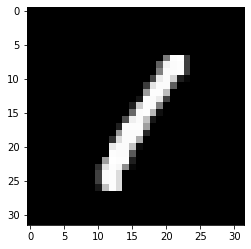

In [148]:
plt.imshow(ones_32[0],cmap='gray')